<a href="https://colab.research.google.com/github/santiric/Distracted-Driving-Risk-Detection-Challenge/blob/main/Driving_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Riccardo Santi* - 2182525 - *Scienze Statistiche*



# **Distracted Driving Risk Detection Challenge**

Vivan Doshi. Distracted Driving Risk Detection Challenge. https://kaggle.com/competitions/distracted-driving-risk-detection-challenge, 2025. Kaggle.

## Abstract

This work addresses a classification problem from a recent Kaggle competition. The challenge involves developing a model to classify driving risk levels using real-world time series data collected from urban driving sessions. The goal is to predict whether a given driving situation corresponds to a low, medium, high, or very high accident risk.

In this study, I approach the dataset with multiple objectives. The first, explored in the following sections, is to develop an interpretable model that explains how different covariates contribute to the predicted risk levels.

**Getting the dataset via Kaggle API**

**Step 1**: Install the Kaggle API

In [ ]:
!pip install -q kaggle

**Step 2**: Join the Competition

Before anyone can download the data, they must join the competition on Kaggle.

Go to the competition page linked above.

Click “Join Competition” and accept the rules.

Important: Without joining, the Kaggle API will return a 403 error.

**Step 3**: Upload Your Kaggle API Token

Each user needs their own Kaggle API token.

Go to your Kaggle account → Settings → API → Create New Token.

Download the kaggle.json file.

Then, run this cell to upload it:

In [ ]:
from google.colab import files
uploaded = files.upload()  # select your kaggle.json


Saving kaggle.json to kaggle.json


**Step 4**: Set Up Kaggle API Credentials

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


**Step 5**: Download the Competition Data

In [ ]:
# Download the competition data to /content
!kaggle competitions download -c distracted-driving-risk-detection-challenge -p /content --quiet


**Step 6**: Extract the Data

In [ ]:
%%bash
mkdir -p /content/dataset

# Extract all zip files
for f in /content/*.zip; do
  unzip -q "$f" -d /content/dataset
done

# Check the files
ls -lh /content/dataset


total 20M
-rw-r--r-- 1 root root  16M Sep 30 22:30 kaggle_full_unlabeled_data.csv
-rw-r--r-- 1 root root 171K Sep 30 22:30 kaggle_sample_submission.csv
-rw-r--r-- 1 root root 3.2M Sep 30 22:30 kaggle_test.csv
-rw-r--r-- 1 root root 264K Sep 30 22:30 kaggle_train.csv


Let's check the dataset:

In [ ]:
import pandas as pd
print(pd.read_csv("/content/dataset/kaggle_train.csv").head())


   observation_hour  speed    rpm  acceleration  throttle_position  \
0              15.0    0.0  891.0           0.0               21.6   
1              15.0    0.0  888.0           0.0               21.2   
2              15.0    0.0  890.0           0.0               21.2   
3              15.0    0.0  902.0           0.0               21.2   
4              15.0    0.0  891.0           0.0               20.4   

   engine_temperature  engine_load_value  heart_rate  current_weather  \
0               109.0               24.7        73.0              9.0   
1               105.0               23.1        85.0              9.0   
2               101.0               23.1        82.0              9.0   
3               102.0               23.5        72.0              9.0   
4               102.0               22.0        68.0              9.0   

   visibility  precipitation  accidents_onsite  design_speed  accidents_time  \
0        16.1            2.4               9.0          70.0

I know this process is a little bit long. It might be faster to just download the dataset locally from the competition website and then manually upload it in the session.

**The data**

We should always understand our dataset before fitting a model. There is a universal rule we must remember, no matter what method we want to apply: *Garbage in, garbage out*. This means that blindly fitting a model without first asking ourselves about the quality of the data, or whether our data are appropriate for our model or goal, will lead to poor-quality results.

So, let's say we want a communicable model to explain which covariates are more strongly associated with higher levels of risk and which with lower levels of risk. Suppose we decide to use classification trees for *k = 4* possible labels.


In [ ]:
kaggle_train = pd.read_csv("/content/dataset/kaggle_train.csv")
kaggle_test = pd.read_csv("/content/dataset/kaggle_test.csv")

Let's understand our data and perform some data-engineering.

In [ ]:
#the target
kaggle_train

,observation_hour,speed,rpm,acceleration,throttle_position,engine_temperature,engine_load_value,heart_rate,current_weather,visibility,precipitation,accidents_onsite,design_speed,accidents_time,risk_level,label_source
0,15.0,0.0,891.0,0.00,21.6,109.0,24.7,73.0,9.0,16.1,2.4,9.0,70.0,0.0,1,expert_verified
1,15.0,0.0,888.0,0.00,21.2,105.0,23.1,85.0,9.0,16.1,2.4,9.0,70.0,0.0,2,expert_verified
2,15.0,0.0,890.0,0.00,21.2,101.0,23.1,82.0,9.0,16.1,2.4,9.0,70.0,0.0,1,expert_verified
3,15.0,0.0,902.0,0.00,21.2,102.0,23.5,72.0,9.0,16.1,2.4,9.0,70.0,0.0,1,expert_verified
4,15.0,0.0,891.0,0.00,20.4,102.0,22.0,68.0,9.0,16.1,2.4,9.0,70.0,0.0,1,expert_verified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,20.0,84.0,2409.0,-0.49,16.5,89.0,20.4,80.0,7.0,8.0,0.0,11.0,90.0,0.0,1,expert_verified
1976,20.0,85.0,2422.0,0.50,54.9,89.0,89.8,80.0,7.0,8.0,0.0,6.0,90.0,0.0,1,expert_verified
1977,20.0,99.0,2791.0,-0.51,20.8,89.0,40.0,80.0,7.0,8.0,0.0,11.0,70.0,0.0,1,expert_verified
1978,20.0,12.0,1799.0,1.09,18.8,94.0,49.0,91.0,7.0,8.0,0.0,13.0,70.0,0.0,1,expert_verified


We have a description of our dataset in the kaggle competition website, here the main points:

This is time series data from sequential driving sessions. While each row can be treated independently, the temporal relationships contain valuable information.

# Columns

## Target Variable
**risk_level** — Traffic accident risk classification (1 = Low, 2 = Medium, 3 = High, 4 = Very High). This is the variable being predicted. Only present in the training data.

## Vehicle Telemetry Features
**Source:** OBD-II (On-Board Diagnostics) scanner connected to vehicle  
- **speed** — Current vehicle speed in km/h. Range: 0–150+  
- **rpm** — Engine revolutions per minute. Range: 0–7000+  
- **acceleration** — Vehicle acceleration in m/s². Range: -10 to +10  
- **throttle_position** — Throttle pedal position (0–100%)  
- **engine_temperature** — Engine coolant temp (°C). Normal: 80–120°C  
- **engine_load_value** — Engine load (0–100%)

## Driver Health Features
**Source:** Wearable health device  
- **heart_rate** — Driver's heart rate (bpm). Range: 40–200

## Temporal Features
- **observation_hour** — Hour of the day (0–23)

## Weather & Environmental Features
**Source:** Weather API (by GPS)  
- **current_weather** — Encoded weather condition (higher = worse)  
- **visibility** — Visibility in km. Range: 0–20+  
- **precipitation** — Precipitation in mm. Range: 0–50+

## Traffic & Road Infrastructure Features
**Source:** Historical accident DB and road characteristics  
- **accidents_onsite** — Historical fatal accidents at this location. Range: 0–30+  
- **design_speed** — Posted/design speed limit (km/h). Range: 30–90  
- **accidents_time** — Historical fatal accidents during similar time periods. Range: 0–10+



# Some considerations

We want to exploit some of the relationships between observations.

We want to create new, customized, and meaningful variables by combining existing ones (from R^p to R).

Adding transformations (R → R) of individual variables is rather useless when using trees: what really matters is the ordering of the observations with respect to a variable, since the model only needs to decide the optimal split point.

Trees are already effective at capturing interaction effects between covariates. For instance, two successive splits can implement an interaction between two variables.

Tree are good in eliminating irrelevant features, they just ignore them and perform the split in more relevant ones.



### Relationships between istances

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Let's look at the valus of some variables in the order in which they appear, we might observe some relations that are not explicity stated in the dataset description.

Text(0, 0.5, 'Observation Hour')

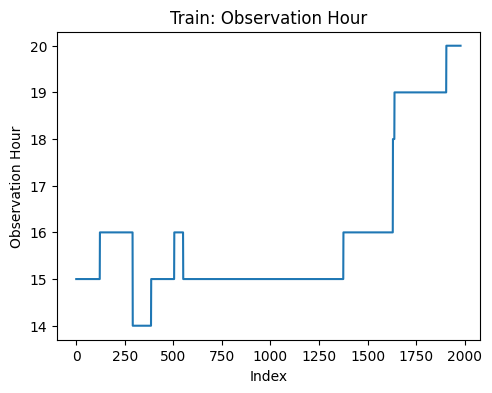

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(kaggle_train['observation_hour'])
plt.title("Train: Observation Hour")
plt.xlabel("Index")
plt.ylabel("Observation Hour")


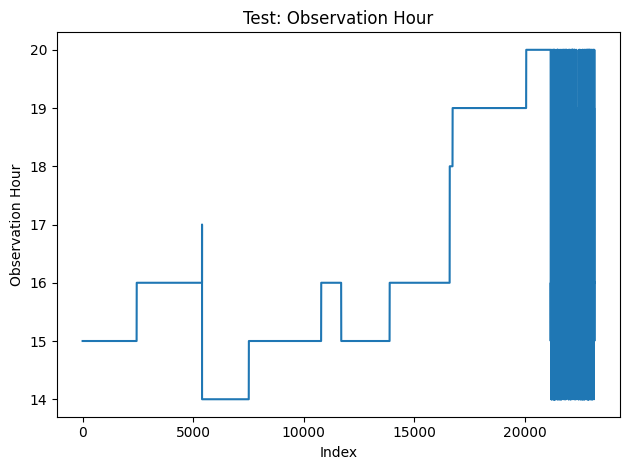

In [ ]:
plt.plot(kaggle_test['observation_hour'])
plt.title("Test: Observation Hour")
plt.xlabel("Index")
plt.ylabel("Observation Hour")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Heart Rate')

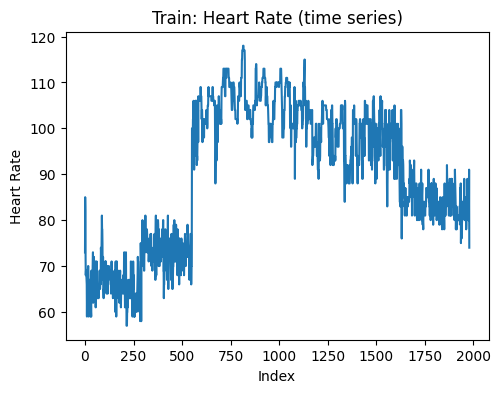

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(kaggle_train['heart_rate'], color='tab:blue')
plt.title("Train: Heart Rate (time series)")
plt.xlabel("Index")
plt.ylabel("Heart Rate")

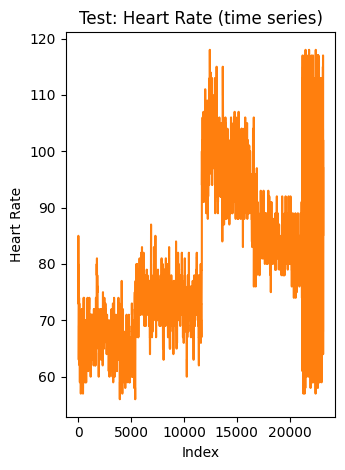

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(kaggle_test['heart_rate'], color='tab:orange')
plt.title("Test: Heart Rate (time series)")
plt.xlabel("Index")
plt.ylabel("Heart Rate")
plt.tight_layout()
plt.show()

We can see groups of consecutive hours that might correspond to the same driving session, and therefore to the same person.

A similar observation can be made for the heart rates: we can see clusters of consecutive observations with similar heart rate values, which probably refer to the same driver.

We want to use this information to create new variables.

Looking at both the difference in the hour variable and the heart rate one we identify the following drivers:

In [ ]:
# --- TRAIN SET ---
driver = np.full(1980, 6)  # same as rep(6,1980)
driver[0:291] = 1
driver[291:551] = 2
driver[551:703] = 3
driver[703:1139] = 4
driver[1139:1640] = 5
kaggle_train['driver'] = driver

# --- TEST SET ---
driver = np.full(23152, 11)  # same as rep(11,23152)
driver[0:5420] = 7
driver[5420:11695] = 8
driver[11695:16350] = 9
driver[16350:21100] = 10
kaggle_test['driver'] = driver

First, let's create some variables that can realistically affect the response: the speed relative to the limit for that segment of the route, and a dummy indicating whether the vehicle is stationary.

In [ ]:
kaggle_train["speed_over_limit"] = kaggle_train["speed"] / kaggle_train["design_speed"]
kaggle_test["speed_over_limit"] = kaggle_test["speed"] / kaggle_test["design_speed"]

kaggle_train["speed_0"] = kaggle_train["speed"] == 0
kaggle_test["speed_0"] = kaggle_test["speed"] == 0

Now, let's exploit the relationship between istances startifying for the driver.
A good idea might be to create new features that compare each value of a variable to the average value for the same driver.

In [ ]:
def rescale_for_driver(df, var):
    """
    Computes var_ratio = var / mean(var) per driver.
    Removes the temporary mean column, like in the R code.
    """
    mean_col = f"mean_{var}_driver"
    ratio_col = f"{var}_ratio"

    df[mean_col] = df.groupby("driver")[var].transform("mean")
    df[ratio_col] = df[var] / df[mean_col]
    df = df.drop(columns=[mean_col])
    return df

# High values of heart rate might be indicators of high-risk situations.
# An heart rate value is high if it's above the mean for the driver!
# Different drivers have different levels of health, so it's better to differentiate between them.

kaggle_train = rescale_for_driver(kaggle_train, "heart_rate")
kaggle_test = rescale_for_driver(kaggle_test, "heart_rate")


# --- APPLY TO OTHER VARIABLES IN BULK (no huge harm if they are useless) ---

for v in ["speed","rpm", "acceleration", "throttle_position", "engine_temperature", "engine_load_value"]:
    kaggle_train = rescale_for_driver(kaggle_train, v)
    kaggle_test = rescale_for_driver(kaggle_test, v)

In [ ]:
kaggle_train = kaggle_train.drop(columns=["label_source", "driver"])
kaggle_test = kaggle_test.drop(columns=["label_source", "driver"])
#no use anymore

#Classification trees

First, let's fit a binary tree (split in two subtrees at each split) that is not too deep. We want to interpret the results.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

X = kaggle_train.drop(columns=["risk_level"])
y = kaggle_train["risk_level"]

#we set a maximum depth for the tree, or else we are going to lose the interpretability
clf = DecisionTreeClassifier(max_depth=3, random_state=42, criterion="entropy")

clf.fit(X, y)

#Predictions on the same training set (on a test set later)
y_pred = clf.predict(X)

# Evaluate training performance
print("Training Accuracy:", (y_pred == y).mean())



Training Accuracy: 0.6762626262626262


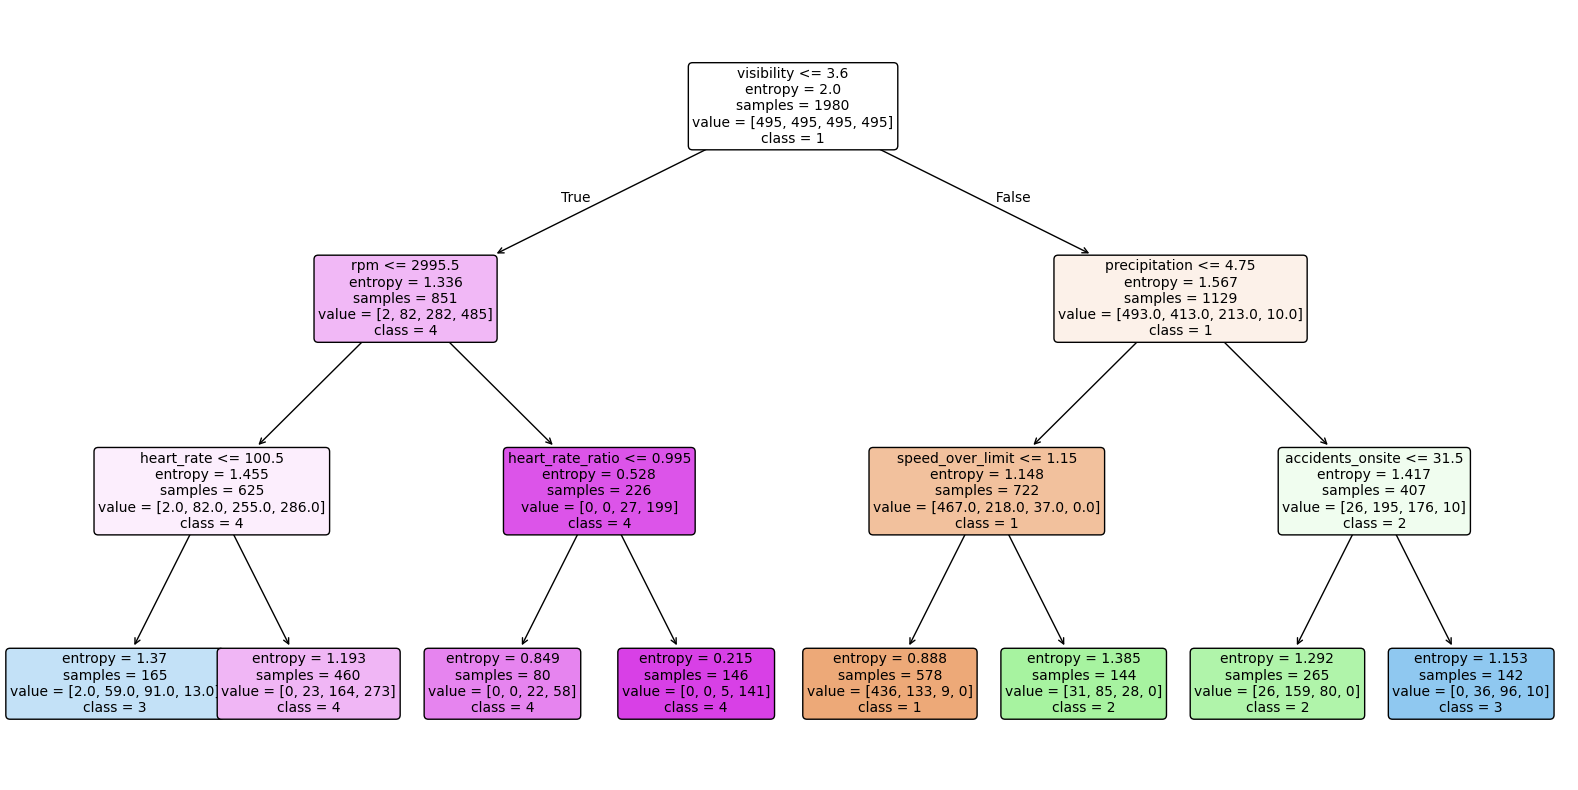

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Set figure size
plt.figure(figsize=(20, 10))

# Plot the tree
plot_tree(
    clf,                      # the fitted DecisionTreeClassifier
    feature_names=X.columns,  # names of the features
    class_names=[str(c) for c in clf.classes_],  # class labels as strings
    filled=True,              # color nodes by class
    rounded=True,             # rounded corners for nodes
    fontsize=10
)

plt.show()


We get a quick overview of which variables are most important for the classification.

Moreover, we can clearly explain which explanatory variables are most associated with high-risk situations. For example, in situations of low visibility, high car RPM, and a high heart_rate_ratio, we observe the highest level of risk.

A noteworthy point: the custom variable we created, heart_rate_ratio, is not only important but also behaves exactly as we intended. For values above the driver-specific mean (≈0.995, roughly 1), the risk increases. It is truly satisfying to see that careful feature engineering before fitting a model can be even more crucial than many other choices regarding the model itself.

Now we need to evaluate the performance of our model on an external dataset. We do this using the test dataset, for which we do not have the true labels. To assess accuracy, we need to upload our predictions to the Kaggle competition website, which will provide the official evaluation.

In [ ]:
# --- Predict on the test set ---
X_test = kaggle_test  # all columns are features
y_pred = clf.predict(X_test).astype(int)

submission = pd.DataFrame({
    "id": np.arange(len(kaggle_test)),  # 0, 1, 2, ...
    "risk_level": y_pred
})

submission.to_csv("submission.csv", index=False)
print("Submission saved to 'submission.csv' (columns: id, risk_level)")

Submission saved to 'submission.csv' (columns: id, risk_level)


The accuracy score is 0.73765, let's compare it with a random prediction uniformly generated:

In [ ]:
pd.DataFrame({
    "id": np.arange(len(kaggle_test)),
    "risk_level": np.random.randint(1, 5, size=len(kaggle_test))  # 1,2,3,4 uniform
}).to_csv("submission_uniform_random.csv", index=False)

Accuracy for a random prediction turns out to be 0.25039, the difference between this and a simple tree model is astonishing.

## A better bias-variance tradeoff for trees

For every task we have in statistics we need to choose our model considering the eternal question of the statistician: how can I obtain the best bias–variance tradeoff? Nothing is free: usually decreasing the bias increases the variance and vice-versa.

Single decision trees are not ideal for classification tasks with complex relationships between variables. To decrease bias we could allow more splits and grow a much deeper tree, but this would drastically increase variance. A better approach is to use a validation set or cross-validation to select an optimal pruning level.

In the CART framework this is done through **cost-complexity pruning**, where we define a penalised objective

$$
R_{\alpha}(T) = R(T) + \alpha \, |T|,
$$

where $R(T)$ is the empirical error (or impurity, entropy for example), $|T|$ is the number of terminal nodes, and $\alpha \ge 0$ is a complexity penalty. As $\alpha$ increases, the algorithm generates a **sequence of nested subtrees**, each obtained by pruning the weakest split. The nested structure is straightforward to see: the complexity penalty does not interact with the usual cost function, so the added term only controls the size of the tree, not its shape. Increasing $\alpha$ therefore produces a sequence of subtrees that are nested by construction.
This nested structure makes the procedure computationally efficient, because we only need to evaluate a grid possible $\alpha$ applied on the same tree instead of many different trees.

We then use cross-validation to choose the value of $\alpha$ that minimises the validation error. The resulting subtree provides a data-driven compromise between bias and variance.

In practice, additional controls such as limiting the maximum depth or requiring a minimum number of samples to split or to form a leaf can also regulate the complexity of the tree. However, cross-validation is usually preferred, since alternative approaches—such as selecting the number of nodes using an AIC-type criterion—are known to lead to overfitting.

The fact that $\alpha$ summarises all the information needed to decide where to prune the tree means that, once the optimal value is chosen, we can refit the subtree that minimises $R_{\alpha}(T)$ using the entire dataset.




In [ ]:
#Let's create a grid of many possibilities for alpha with the following function:
alphas = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X, y).ccp_alphas
print(alphas)

[0.         0.00045914 0.00046296 0.00046898 0.00047138 0.00047847
 0.00048975 0.0004902  0.00049062 0.00049102 0.00049357 0.00049634
 0.00050134 0.00050334 0.00050505 0.00060606 0.0006734  0.0006734
 0.0006734  0.0006734  0.00071829 0.00075758 0.00075758 0.00075758
 0.00075758 0.00075758 0.00075758 0.00078348 0.00080808 0.00080808
 0.00081617 0.00082023 0.0008658  0.0008658  0.0008658  0.00088384
 0.00088384 0.00088384 0.00088384 0.00088384 0.00088384 0.00089787
 0.00090316 0.00090909 0.00092187 0.00092673 0.00092896 0.00093123
 0.00094276 0.00094327 0.00096083 0.000962   0.00096618 0.00096906
 0.00097764 0.00097803 0.00097949 0.00099494 0.00105857 0.00112233
 0.00115167 0.00116529 0.00126065 0.00126263 0.00127714 0.0013468
 0.0013468  0.00136364 0.00140429 0.001443   0.001443   0.001443
 0.001443   0.00144701 0.00151515 0.00157777 0.00167162 0.00176612
 0.00180689 0.0018205  0.00183686 0.0018575  0.00186869 0.00188057
 0.00188811 0.001911   0.0019288  0.00193284 0.00194724 0.00194805

A couple of precisation of the code above:

- the parameter random_state is just for deciding how to split in case of two splits bringing the same
decrease in entropy, if that's not the case the process is purely deterministic.

- The pruning parameter is often called cp, that just to explain the name of the operator

Now let's find the best parameter accordingly to cross-validation:


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

grid = GridSearchCV(DecisionTreeClassifier(random_state=1),
                    {"ccp_alpha": alphas},
                    cv=StratifiedKFold(5, shuffle=True, random_state=1),
                    scoring="accuracy", n_jobs=-1).fit(X, y) #n_jobs is a to use gpu for parallel computation

best_alpha = grid.best_params_["ccp_alpha"]
print(best_alpha)

0.001404286770140429


Precisely, the dataset is split into 5 parts (“folds”).

The model is trained 5 times, each time using 4 folds for training and 1 fold for validation, each fold gets a turn as the validation set.

“Stratified” means each fold preserves the original class distribution. The classes are balanced so it's not a big deal but it's probably better this way.

For each fold the best alpha was chosen in term of accuracy.

At the end, the alpha with the best average accuaracy wins.





Now let's refit on the whole dataset:

In [ ]:
final_tree = DecisionTreeClassifier(random_state=1, ccp_alpha=best_alpha).fit(X, y)
print("best_alpha =", best_alpha, "nodes =", final_tree.tree_.node_count, "leaves =", final_tree.get_n_leaves())

best_alpha = 0.001404286770140429 nodes = 189 leaves = 95


We now have 95 terminal nodes, far more than the 8 we had previously, but still much fewer than the maximum possible, which would equal the number of observations. So, we obtain an intermediate model between the extreme biased one (simple tree) and the extreme variable one (full-frown).

We evaluate on the test set:

In [ ]:
# --- Predict on the test set using final_tree ---
X_test = kaggle_test  # all columns are features
y_pred = final_tree.predict(X_test).astype(int)

submission = pd.DataFrame({
    "id": np.arange(len(kaggle_test)),  # 0, 1, 2, ...
    "risk_level": y_pred
})

submission.to_csv("submission_final_tree.csv", index=False)
print("Submission saved to 'submission_final_tree.csv' (columns: id, risk_level)")


Submission saved to 'submission_final_tree.csv' (columns: id, risk_level)


The scored accuracy on the independent test set is 0.83542, defenitely an upgrade. But again, everything comes with a cost! We lost the interpretability.

##Random forests


Random forests improve single decision trees by averaging an ensemble of \(T\) unpruned trees. Two key mechanisms introduce diversity among trees:

- **Bootstrap sampling:** each tree is built on a bootstrap sample of the training data.
- **Feature subsetting:** at each split, only a random subset of $m$ features (out of $d$) is considered.

Each individual tree is grown deep (that is, every node contains 1 observation), resulting in low bias but really high variance. Averaging predictions over many trees substantially reduces variance while leaving bias roughly unchanged. Since all trees are trained from the same distribution, the expected prediction of the ensemble equals the expected prediction of any single tree. The gain comes from reducing the variance of the aggregated estimator.

Reducing the number of features $m$ considered at each split can slightly increase the bias of individual trees, because the set of candidate splits is restricted. However, the variance reduction achieved by decorrelating the trees typically dominates, so random forests achieve low bias and substantially reduced variance.

The variance of the ensemble prediction satisfies

$$
\mathrm{Var}_{\mathrm{RF}}
= \rho\,\sigma^2 \;+\; \frac{1-\rho}{T}\,\sigma^2,
$$

where $\sigma^2$ is the variance of a single tree and $\rho$ is the average correlation between tree outputs.

For classification, predictions are combined by majority vote, that is, every unpruned tree make a prediction like usual, then the most chosen class is the final prediction.

For more details, see Breiman (2001).

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=10000,      # number of trees
    criterion='entropy',     # function to measure split quality
    max_depth=None,          # no max depth, fully grown trees
    min_samples_split=2,     # min samples to split an internal node, so essentially
                             # you can always split
    min_samples_leaf=1,      # min samples at a leaf node
    max_features='sqrt',     # number of features to consider at each split, we use
                             # sqrt(total number of variables) for each split decision
                             # that's what literature tipically suggests
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,          # use bootstrap samples
    oob_score=False,         # do not compute out-of-bag score
    n_jobs=-1,               # use all cores
    random_state=1,         # reproducible (here randomness is in the process! we are bootstrapping)
)

rf.fit(X, y)

y_pred = rf.predict(kaggle_test).astype(int)

submission = pd.DataFrame({
    "id": np.arange(len(kaggle_test)),
    "risk_level": y_pred
})
submission.to_csv("submission_rf_10000.csv", index=False)
print("Saved submission_rf.csv")

Saved submission_rf.csv


The accuracy on the test set is 0.90050. Here the interpretability is completely lost.